## Analysis of Chapter 4 data
This notebook reproduces the analyses presented in Chapter 4 of the dissertation.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from scipy.stats import ttest_rel

sns.set(style='whitegrid')


In [3]:
# Load PD and GC tables from CSV files instead of embedded text
pd_table_path = '../data/derived/pd_table.csv'
gc_table_path = '../data/derived/gc_table.csv'

pd_df = pd.read_csv(pd_table_path)
gc_df = pd.read_csv(gc_table_path)

# Map prompt types
prompt_types = ['baseline','cot_then_optimize','eff_from_scratch','tagged_explained']

def parse_variant(v):
    for p in prompt_types:
        if v.endswith(p):
            model = v[:-len(p)-1]
            return model, p
    return v, 'unknown'

pd_df[['model','prompt_type']] = pd_df['variant'].apply(lambda v: pd.Series(parse_variant(v)))
gc_df[['model','prompt_type']] = gc_df['variant'].apply(lambda v: pd.Series(parse_variant(v)))

# Filter for correct runs
pd_df_correct = pd_df[pd_df['correct']==1].copy()
gc_df_correct = gc_df[gc_df['correct']==1].copy()

pd_df_correct.head()

,task_id,variant,correct,pd_runtime,pd_memory,pd_flops,pd_energy,model,prompt_type
0,cache_with_expiry,deepseek-coder_6_7b_baseline,1,-0.004282,0.000043,0.0,0.007812,deepseek-coder_6_7b,baseline
1,cache_with_expiry,deepseek-coder_6_7b_cot_then_optimize,1,-0.005800,-0.000043,0.0,-0.009766,deepseek-coder_6_7b,cot_then_optimize
2,cache_with_expiry,deepseek-coder_6_7b_eff_from_scratch,1,-0.010908,-0.000043,0.0,-0.011719,deepseek-coder_6_7b,eff_from_scratch
3,cache_with_expiry,deepseek-coder_6_7b_tagged_explained,1,-0.019660,0.000043,0.0,-0.031250,deepseek-coder_6_7b,tagged_explained
4,cache_with_expiry,qwen2_5-coder_7b_baseline,1,0.004282,-0.000043,0.0,-0.007812,qwen2_5-coder_7b,baseline


### Descriptive statistics

In [4]:

# Function to compute descriptive statistics

def descriptive_stats(df, metric):
    summary = df.groupby(['model','prompt_type'])[metric].agg(['mean','std','count']).reset_index()
    summary['ci95'] = 1.96 * summary['std'] / np.sqrt(summary['count'])
    return summary

runtime_stats = descriptive_stats(pd_df_correct, 'pd_runtime')
energy_stats = descriptive_stats(pd_df_correct, 'pd_energy')

runtime_stats, energy_stats


(                 model        prompt_type      mean       std  count      ci95
 0  deepseek-coder_6_7b           baseline -0.043187  0.042732      5  0.037457
 1  deepseek-coder_6_7b  cot_then_optimize -0.024833  0.055031      6  0.044034
 2  deepseek-coder_6_7b   eff_from_scratch  0.222295  0.333500      4  0.326830
 3  deepseek-coder_6_7b   tagged_explained  0.018202  0.048512      5  0.042523
 4     qwen2_5-coder_7b           baseline  0.043187  0.042732      5  0.037457
 5     qwen2_5-coder_7b  cot_then_optimize  0.034626  0.044338      5  0.038864
 6     qwen2_5-coder_7b   eff_from_scratch  0.023057  0.080825      5  0.070846
 7     qwen2_5-coder_7b   tagged_explained  0.053597  0.053255      5  0.046680,
                  model        prompt_type      mean       std  count      ci95
 0  deepseek-coder_6_7b           baseline  0.008340  0.010533      5  0.009233
 1  deepseek-coder_6_7b  cot_then_optimize -0.042630  0.028287      6  0.022634
 2  deepseek-coder_6_7b   eff_from_scra

### Green capacity statistics

In [5]:

# Compute GC statistics

gc_stats = gc_df_correct.groupby(['model','prompt_type'])['gc'].agg(['mean','std','count']).reset_index()
gc_stats['ci95'] = 1.96 * gc_stats['std'] / np.sqrt(gc_stats['count'])
gc_stats


,model,prompt_type,mean,std,count,ci95
0,deepseek-coder_6_7b,baseline,0.010513,0.010120,5,0.008871
1,deepseek-coder_6_7b,cot_then_optimize,0.111034,0.254344,6,0.203517
2,deepseek-coder_6_7b,eff_from_scratch,0.225022,0.330993,4,0.324373
3,deepseek-coder_6_7b,tagged_explained,0.034310,0.036221,5,0.031749
4,qwen2_5-coder_7b,baseline,0.059414,0.060552,5,0.053077
5,qwen2_5-coder_7b,cot_then_optimize,0.051797,0.070858,5,0.062110
6,qwen2_5-coder_7b,eff_from_scratch,0.077340,0.075557,5,0.066228
7,qwen2_5-coder_7b,tagged_explained,0.066384,0.036459,5,0.031958


### Visualisations

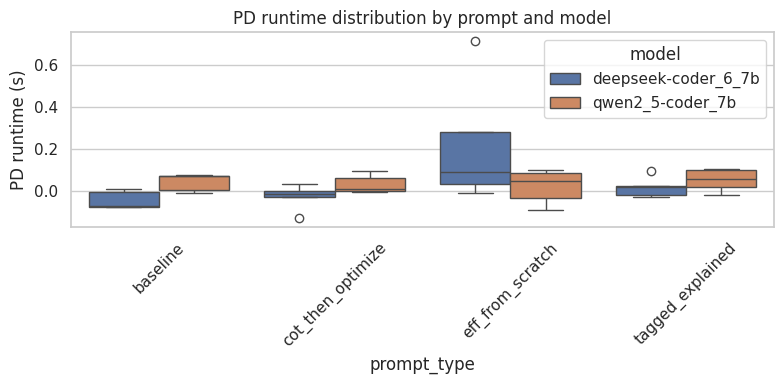

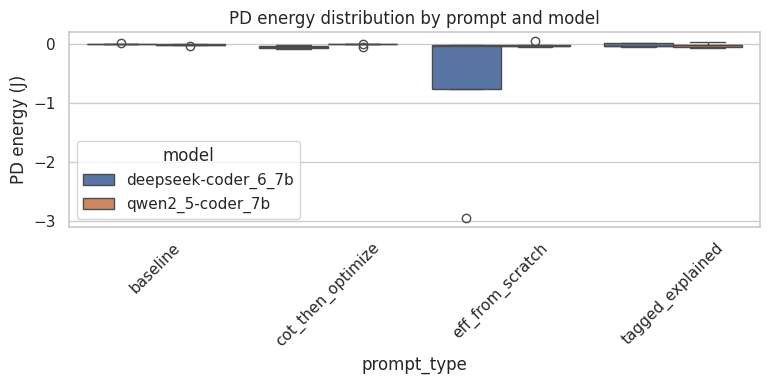

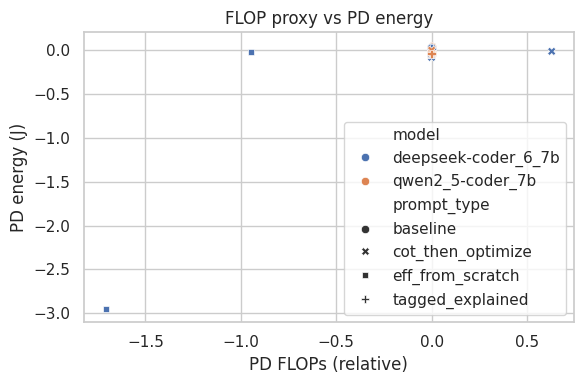

In [6]:

# Create boxplots for runtime and energy
plt.figure(figsize=(8,4))
sns.boxplot(x='prompt_type', y='pd_runtime', hue='model', data=pd_df_correct)
plt.title('PD runtime distribution by prompt and model')
plt.ylabel('PD runtime (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='prompt_type', y='pd_energy', hue='model', data=pd_df_correct)
plt.title('PD energy distribution by prompt and model')
plt.ylabel('PD energy (J)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot for FLOP proxy vs energy
plt.figure(figsize=(6,4))
sns.scatterplot(x='pd_flops', y='pd_energy', hue='model', style='prompt_type', data=pd_df_correct)
plt.title('FLOP proxy vs PD energy')
plt.xlabel('PD FLOPs (relative)')
plt.ylabel('PD energy (J)')
plt.tight_layout()
plt.show()


### Prompt engineering effects

In [7]:

# Define paired t-test and effect size calculations

def compare_baseline_vs_prompt(metric, prompt, model):
    baseline_df = pd_df_correct[(pd_df_correct['model']==model)&(pd_df_correct['prompt_type']=='baseline')][['task_id',metric]]
    prompt_df = pd_df_correct[(pd_df_correct['model']==model)&(pd_df_correct['prompt_type']==prompt)][['task_id',metric]]
    merged = baseline_df.merge(prompt_df, on='task_id', suffixes=('_baseline','_prompt'))
    if len(merged) < 2:
        return None
    t_stat, p_val = ttest_rel(merged[metric+'_baseline'], merged[metric+'_prompt'])
    diff = merged[metric+'_baseline'] - merged[metric+'_prompt']
    effect_size = diff.mean() / diff.std(ddof=1) if diff.std(ddof=1)!=0 else 0
    mean_diff = diff.mean()
    ci95 = 1.96 * diff.std(ddof=1) / np.sqrt(len(diff))
    return {'model': model, 'prompt': prompt, 'metric': metric, 'effect_size': effect_size, 'p_val': p_val, 'mean_diff': mean_diff, 'ci95': ci95}

prompts = ['cot_then_optimize','eff_from_scratch','tagged_explained']
results = []
for model in pd_df_correct['model'].unique():
    for metric in ['pd_runtime','pd_energy']:
        for prompt in prompts:
            res = compare_baseline_vs_prompt(metric, prompt, model)
            if res:
                results.append(res)

effects_df = pd.DataFrame(results)
effects_df


,model,prompt,metric,effect_size,p_val,mean_diff,ci95
0,deepseek-coder_6_7b,cot_then_optimize,pd_runtime,-0.137061,0.774532,-0.012752,0.081551
1,deepseek-coder_6_7b,eff_from_scratch,pd_runtime,-0.790983,0.211804,-0.278953,0.345613
2,deepseek-coder_6_7b,tagged_explained,pd_runtime,-0.835782,0.135008,-0.061389,0.064383
3,deepseek-coder_6_7b,cot_then_optimize,pd_energy,1.639273,0.021476,0.042942,0.022962
4,deepseek-coder_6_7b,eff_from_scratch,pd_energy,0.522879,0.372511,0.764384,1.432638
5,deepseek-coder_6_7b,tagged_explained,pd_energy,0.955361,0.099506,0.023436,0.021503
6,qwen2_5-coder_7b,cot_then_optimize,pd_runtime,0.216187,0.654076,0.008561,0.034710
7,qwen2_5-coder_7b,eff_from_scratch,pd_runtime,0.486387,0.337921,0.020131,0.036278
8,qwen2_5-coder_7b,tagged_explained,pd_runtime,-0.479391,0.344110,-0.010409,0.019033
9,qwen2_5-coder_7b,cot_then_optimize,pd_energy,-0.014827,0.975141,-0.000446,0.026339


### Cross‑model comparisons

In [8]:

# Cross-model differences in mean PD runtime and energy
runtime_cross = pd_df_correct.groupby(['model','prompt_type'])['pd_runtime'].mean().unstack('model')
energy_cross = pd_df_correct.groupby(['model','prompt_type'])['pd_energy'].mean().unstack('model')

# Calculate differences (DeepSeek minus Qwen)
runtime_cross['diff'] = runtime_cross['deepseek-coder_6_7b'] - runtime_cross['qwen2_5-coder_7b']
energy_cross['diff'] = energy_cross['deepseek-coder_6_7b'] - energy_cross['qwen2_5-coder_7b']

runtime_cross, energy_cross


(model              deepseek-coder_6_7b  qwen2_5-coder_7b      diff
 prompt_type                                                       
 baseline                     -0.043187          0.043187 -0.086375
 cot_then_optimize            -0.024833          0.034626 -0.059459
 eff_from_scratch              0.222295          0.023057  0.199238
 tagged_explained              0.018202          0.053597 -0.035395,
 model              deepseek-coder_6_7b  qwen2_5-coder_7b      diff
 prompt_type                                                       
 baseline                      0.008340         -0.008340  0.016679
 cot_then_optimize            -0.042630         -0.007894 -0.034736
 eff_from_scratch             -0.754571         -0.009664 -0.744907
 tagged_explained             -0.015097         -0.013530 -0.001567)